# Raw data alignment

Stig U Andersen, Mikkel H Schierup, Samuele Soraggi

:::{.callout-note title="Tutorial description"}

This tutorial will cover the steps for performing the alignment of raw RNA- and HiFi-sequencing data. You will need to use [the software IGV](https://software.broadinstitute.org/software/igv/download) on your computer to visualize some of the output files, which can be easily downloaded once they are produced. At the end of this tutorial you will be able to:

- perform and discuss quality control on raw data in `fastq` format using `FastQC` and `MultiQC`
- align HiFi and RNA sequencing data with dedicated tools such as `MiniMap2` and `STAR`
- analyze the quality the alignment with `qualimap`

:::

The output of this notebook will be used for the Variant calling
analysis and the bulk RNA-sequencing analysis. If you do not want to run
this notebook, you can alternatively use [the free interactive tool
Galaxy](https://usegalaxy.org/) to perform the alignment steps. We have
uploaded the data on Galaxy, and the manual to perform the exercise is
found [at the course
webpage](https://hds-sandbox.github.io/NGS_summer_course_Aarhus/).

The present tutorial, like the rest of the course material, is available
at our [open-source github
repository](https://github.com/hds-sandbox/NGS_summer_course_Aarhus).

:::{.callout-tip collapse="true" title="A few introductory points to run this notebook"}
  
* To use this notebook, use the `NGS (python)` kernel that contains the packages. Choose it by selecting `Kernel -> Change Kernel` in the menu on top of the window.

<figure>
<img src="images/kernelchoice.png" width="500" alt="Kernel Choice" class="center">
</figure>

* In this notebook you will use only bash commands as you would do in the command line (this is why you read `%%bash` at the beginning of each piece of code). Those commands can be replicated in the command line, but we thought of integrating them in a notebook to make the tutorial understandable. The bash commands can also be marked with an `!` sign at the beginning of the line
* On some computers, you might see the result of the commands once they are done running. This means you will wait some time while the computer is crunching, and only afterwards you will see the result of the command you have executed
*  You can run the code in each cell by clicking on the run cell button, or by pressing <kbd> Shift </kbd> + <kbd> Enter </kbd>.  When the code is done running, a small green check sign will appear on the left side
*   You need to run the cells in sequential order, please do not run a cell until the one above finished running and do not skip any cells
*   Each cell contains a short description of the code and the output you should get. Please try not to focus on understanding the code for each command in too much detail, but rather try to focus on the output 
*   You can create new code cells by pressing <kbd> + </kbd> in the Menu bar above. 
    
:::

# Biological background

White clover (Trifolium repens) is an allotetraploid. It is a relatively
young, outcrossing species, which originated during the most recent
glaciation around 20,000 years ago by hybridisation of two diploid
species, T. occidentale and T. pallescens (see figure below).

<img src="images/white_clover.png" width="700" alt="Kernel Choice" class="center">

This means that it contains genomes originating from two different
species within the same nucleus. Normally, white clover is an
outbreeding species, but a self-compatible line was used for sequencing
the white clover genome [(Griffiths et al,
2019)](https://academic.oup.com/plcell/article/31/7/1466/5985684). This
line will be designated as `S10` in the data, indicating that this is
the 10th self-fertilized generation. In addition, we have data from a
wild clover accession (ecotype) called Tienshan (`Ti`), which is
collected from the Chinese mountains and is adapted to alpine
conditions.

We will perform alignment of the data to the white clover’s reference
genome containing both T. occidentale and T. pallescens (called
`contig 1` and `contig 2` in the data). We will also perform alignment
to each subgenome, and see which are the differences with the quality
control tools.

# Quality control and mapping

## Quality Control

We run `FastQC` on the PacBio Hifi reads and on two of the Illumina
RNA-seq libraries. `FastQC` does quality control of the raw sequence
data, providing an overview of the data which can help identify if there
are any problems that should be addressed before further analysis. You
can find the report for each file into the folder
`results/fastqc_output/`. The output is in HTML format and can be opened
in any browser or in `jupyterlab`. It is however not easy to compare the
various libraries by opening separate reports. To aggregate all the
results, we apply the `MultiQC` software to the reports’ folder. The
output of MultiQC is in the directory
`results/multiqc_output/fastqc_data`.

In [ ]:
%%bash
#run fastqc
mkdir -p results/fastqc_output
fastqc -q -o results/fastqc_output ../Data/Clover_Data/*.fastq  > /dev/null 2>&1

**Note:** `fastqc` prints a lot of output conisting of a simple
confirmation of execution without error, even when using the option
`-q`, which means `quiet`. Therefore we added `> /dev/null 2>&1` to the
command to mute the printing of that output.

In [ ]:
%%bash
#run multiqc
multiqc --outdir results/multiqc_output/fastqc_data results/fastqc_output

<font size="+2"> <b> Questions </b> </font>

Visualize the Webpage generated by MultiQC.

Hint: You can find a `Help` button that offers additional information
about the plots for each panel. Focus on the following panels: “Per base
sequence quality”, “Per sequence quality scores”…. (“Per base sequence
content” always gives a `FAIL` for RNA-seq data).

-   What do you notice with respect to the sequence quality scores?
-   Are there any other quality issues worth noting?

## Hifi data mapping

We map the PacBio Hifi reads (`Hifi_reads_white_clover.fastq`) to the
white clover reference sequence (Contig1&2) using `minimap2`. We run two
mapping rounds, using two different preset options (`-x` in the command)
for the technology: \* PacBio/Oxford Nanopore read to reference mapping:
`map-pb` \* Long assembly to reference mapping. Divergence is below 20%”
settings `asm20`. Next, we create reports of the mapping results by
running `QualiMap` on the two obtained SAM files.

We first need to index the reference fasta files using `samtools faidx`.
This produces files in `.fai` format containing informations about
length of the reference sequence, offset for the quality scores, name of
the reference sequence. [Click
here](http://www.htslib.org/doc/faidx.html) for a detailed overview.

In [ ]:
%%bash
#copy the reference data in the folder reference_data, so that you can write the indexing files
mkdir -p reference_data
cp ../Data/Clover_Data/DNA_Contig1_2.fasta ../Data/Clover_Data/DNA_Contig1.fasta ../Data/Clover_Data/DNA_Contig2.fasta reference_data

In [ ]:
%%bash
samtools faidx reference_data/DNA_Contig1_2.fasta
samtools faidx reference_data/DNA_Contig1.fasta
samtools faidx reference_data/DNA_Contig2.fasta

we create an output folder for the HIFI alignment, and run `minimap2`
with the settings explained before.

In [ ]:
%%bash 
mkdir -p results/HIFI_alignment/
minimap2 -a -x map-pb -o results/HIFI_alignment/PacBio_clover_alignment_1_2_mappb.sam \
                            reference_data/DNA_Contig1_2.fasta \
                            ../Data/Clover_Data/Hifi_reads_white_clover.fastq 

minimap2 -a -x asm20 -o results/HIFI_alignment/PacBio_clover_alignment_1_2_asm20.sam \
                            reference_data/DNA_Contig1_2.fasta \
                            ../Data/Clover_Data/Hifi_reads_white_clover.fastq

`samtools sort` is used to sort the alignment with left-to-right
coordinates. The output is in `.bam` format, with `.sam` files in input
(Note that you could have gotten `.bam` files from `minimap2` with a
specific option).

In [ ]:
%%bash
samtools sort results/HIFI_alignment/PacBio_clover_alignment_1_2_mappb.sam \
                -o results/HIFI_alignment/PacBio_clover_alignment_1_2_mappb.sort.bam

samtools sort results/HIFI_alignment/PacBio_clover_alignment_1_2_asm20.sam \
                -o results/HIFI_alignment/PacBio_clover_alignment_1_2_asm20.sort.bam

`samtools index` creates the index for the `bam` file, stored in `.bai`
format. The index file lets programs access any position into the
aligned data without reading the whole file, which would take too much
time.

In [ ]:
%%bash
samtools index results/HIFI_alignment/PacBio_clover_alignment_1_2_mappb.sort.bam
samtools index results/HIFI_alignment/PacBio_clover_alignment_1_2_asm20.sort.bam

Run quality control on both files

In [ ]:
%%bash
qualimap bamqc -bam results/HIFI_alignment/PacBio_clover_alignment_1_2_mappb.sort.bam \
                 -outdir results/qualimap_output/PacBio_clover_alignment_1_2_mappb

qualimap bamqc -bam results/HIFI_alignment/PacBio_clover_alignment_1_2_asm20.sort.bam \
                 -outdir results/qualimap_output/PacBio_clover_alignment_1_2_asm20

For easier comparison, we can again collapse the two reports into a
single one using `MultiQC`, in the same way we did for putting together
the other reports from `fastQC`.

In [ ]:
%%bash

#run multiqc
multiqc --outdir results/qualimap_output results/qualimap_output

Now you can visualize the report generated, which is in
`results/qualimap_output/multiqc_report.html`.

Next, we map the white clover PacBio Hifi reads to contig1 and contig2
separately, using the setting you selected at the previous step (let’s
say `map-pb` was chosen, but you are free to change this setting in the
commands). As the two contigs represent the two white clover subgenomes,
this mapping will allow you to see the two subgenome haplotypes and call
subgenome SNPs.

In [ ]:
%%bash 
minimap2 -a -x map-pb -o results/HIFI_alignment/PacBio_clover_alignment_1.sam \
                            reference_data/DNA_Contig1.fasta \
                            ../Data/Clover_Data/Hifi_reads_white_clover.fastq

In [ ]:
%%bash 
minimap2 -a -x map-pb -o results/HIFI_alignment/PacBio_clover_alignment_2.sam \
                            reference_data/DNA_Contig2.fasta \
                            ../Data/Clover_Data/Hifi_reads_white_clover.fastq

Sort the bam files and create their index using `samtools`

In [ ]:
%%bash
samtools sort results/HIFI_alignment/PacBio_clover_alignment_1.sam -o results/HIFI_alignment/PacBio_clover_alignment_1.sort.bam
samtools sort results/HIFI_alignment/PacBio_clover_alignment_2.sam -o results/HIFI_alignment/PacBio_clover_alignment_2.sort.bam

In [ ]:
%%bash
samtools index results/HIFI_alignment/PacBio_clover_alignment_1.sort.bam
samtools index results/HIFI_alignment/PacBio_clover_alignment_2.sort.bam

Perform quality control

In [ ]:
%%bash
mkdir -p results/qualimap_output
qualimap bamqc -bam results/HIFI_alignment/PacBio_clover_alignment_1.sort.bam -outdir results/qualimap_output/PacBio_clover_alignment_1

In [ ]:
%%bash
qualimap bamqc -bam results/HIFI_alignment/PacBio_clover_alignment_2.sort.bam -outdir results/qualimap_output/PacBio_clover_alignment_2

In [ ]:
%%bash

#run multiqc
multiqc --outdir results/qualimap_output results/qualimap_output

<font size="+2"> <b> Task: IGV visualization and Questions </b> </font>

Now you can inspect the alignment files in `IGV`.

-   First, you will need to download the reference fasta sequence in
    `../Data/Clover_Data/DNA_Contig1_2.fasta` and import it into IGV.
    You can do the same for the files `DNA_Contig1.fasta` and
    `DNA_Contig2.fasta` that you might need later. In IGV, this is done
    with the menu `Genomes --> Load Genome from file` menu and by
    selecting the relevant fasta file. Then, choose the reference you
    need from the drop-down menu (see figure below).
    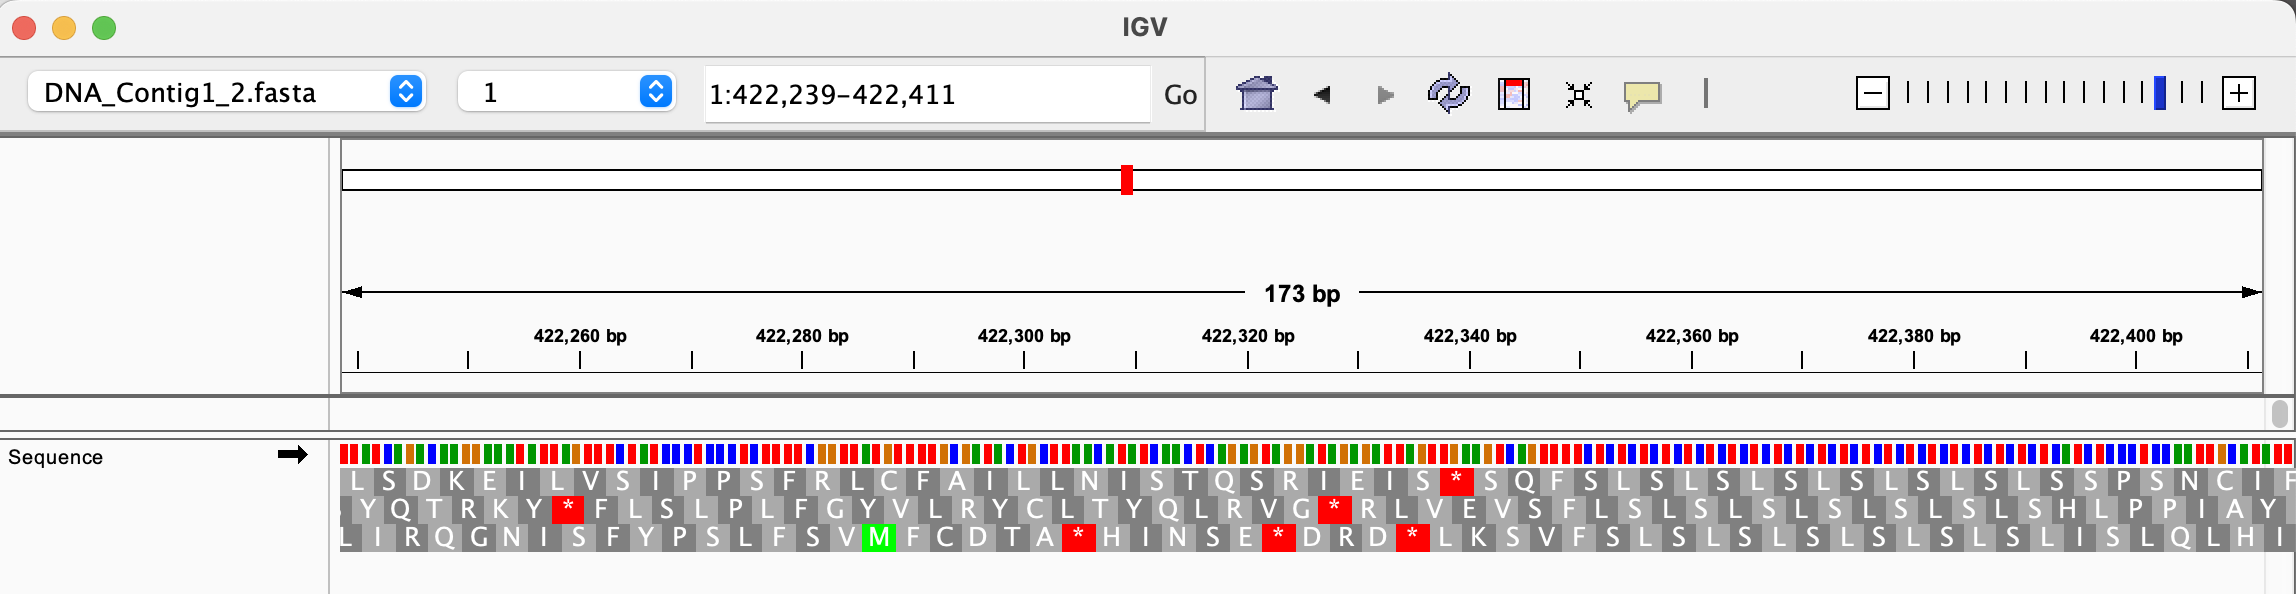 You will not yet see much, but
    you can choose one of the two subgenomes (contig 1 or 2) and double
    click on a chromosome position to inspect the reference sequence.
    The next step will visualize the mapped files on IGV.

-   Each mapped genome can be seen in IGV against the reference file of
    choice. To load an aligned file, first download it together with the
    index file in `.bai` format. For example, you need to download both
    `results/HIFI_alignment/PacBio_clover_alignment_1.sort.bam` and
    `results/HIFI_alignment/PacBio_clover_alignment_1.sort.bam.bai` to
    see this alignment (you need to open only the `.bam` file with IGV).
    If you open more files, their alignments will be distributed in the
    IGV interface, and you can change the size of each visualization
    yourself (below shown with only one opened alignment).
    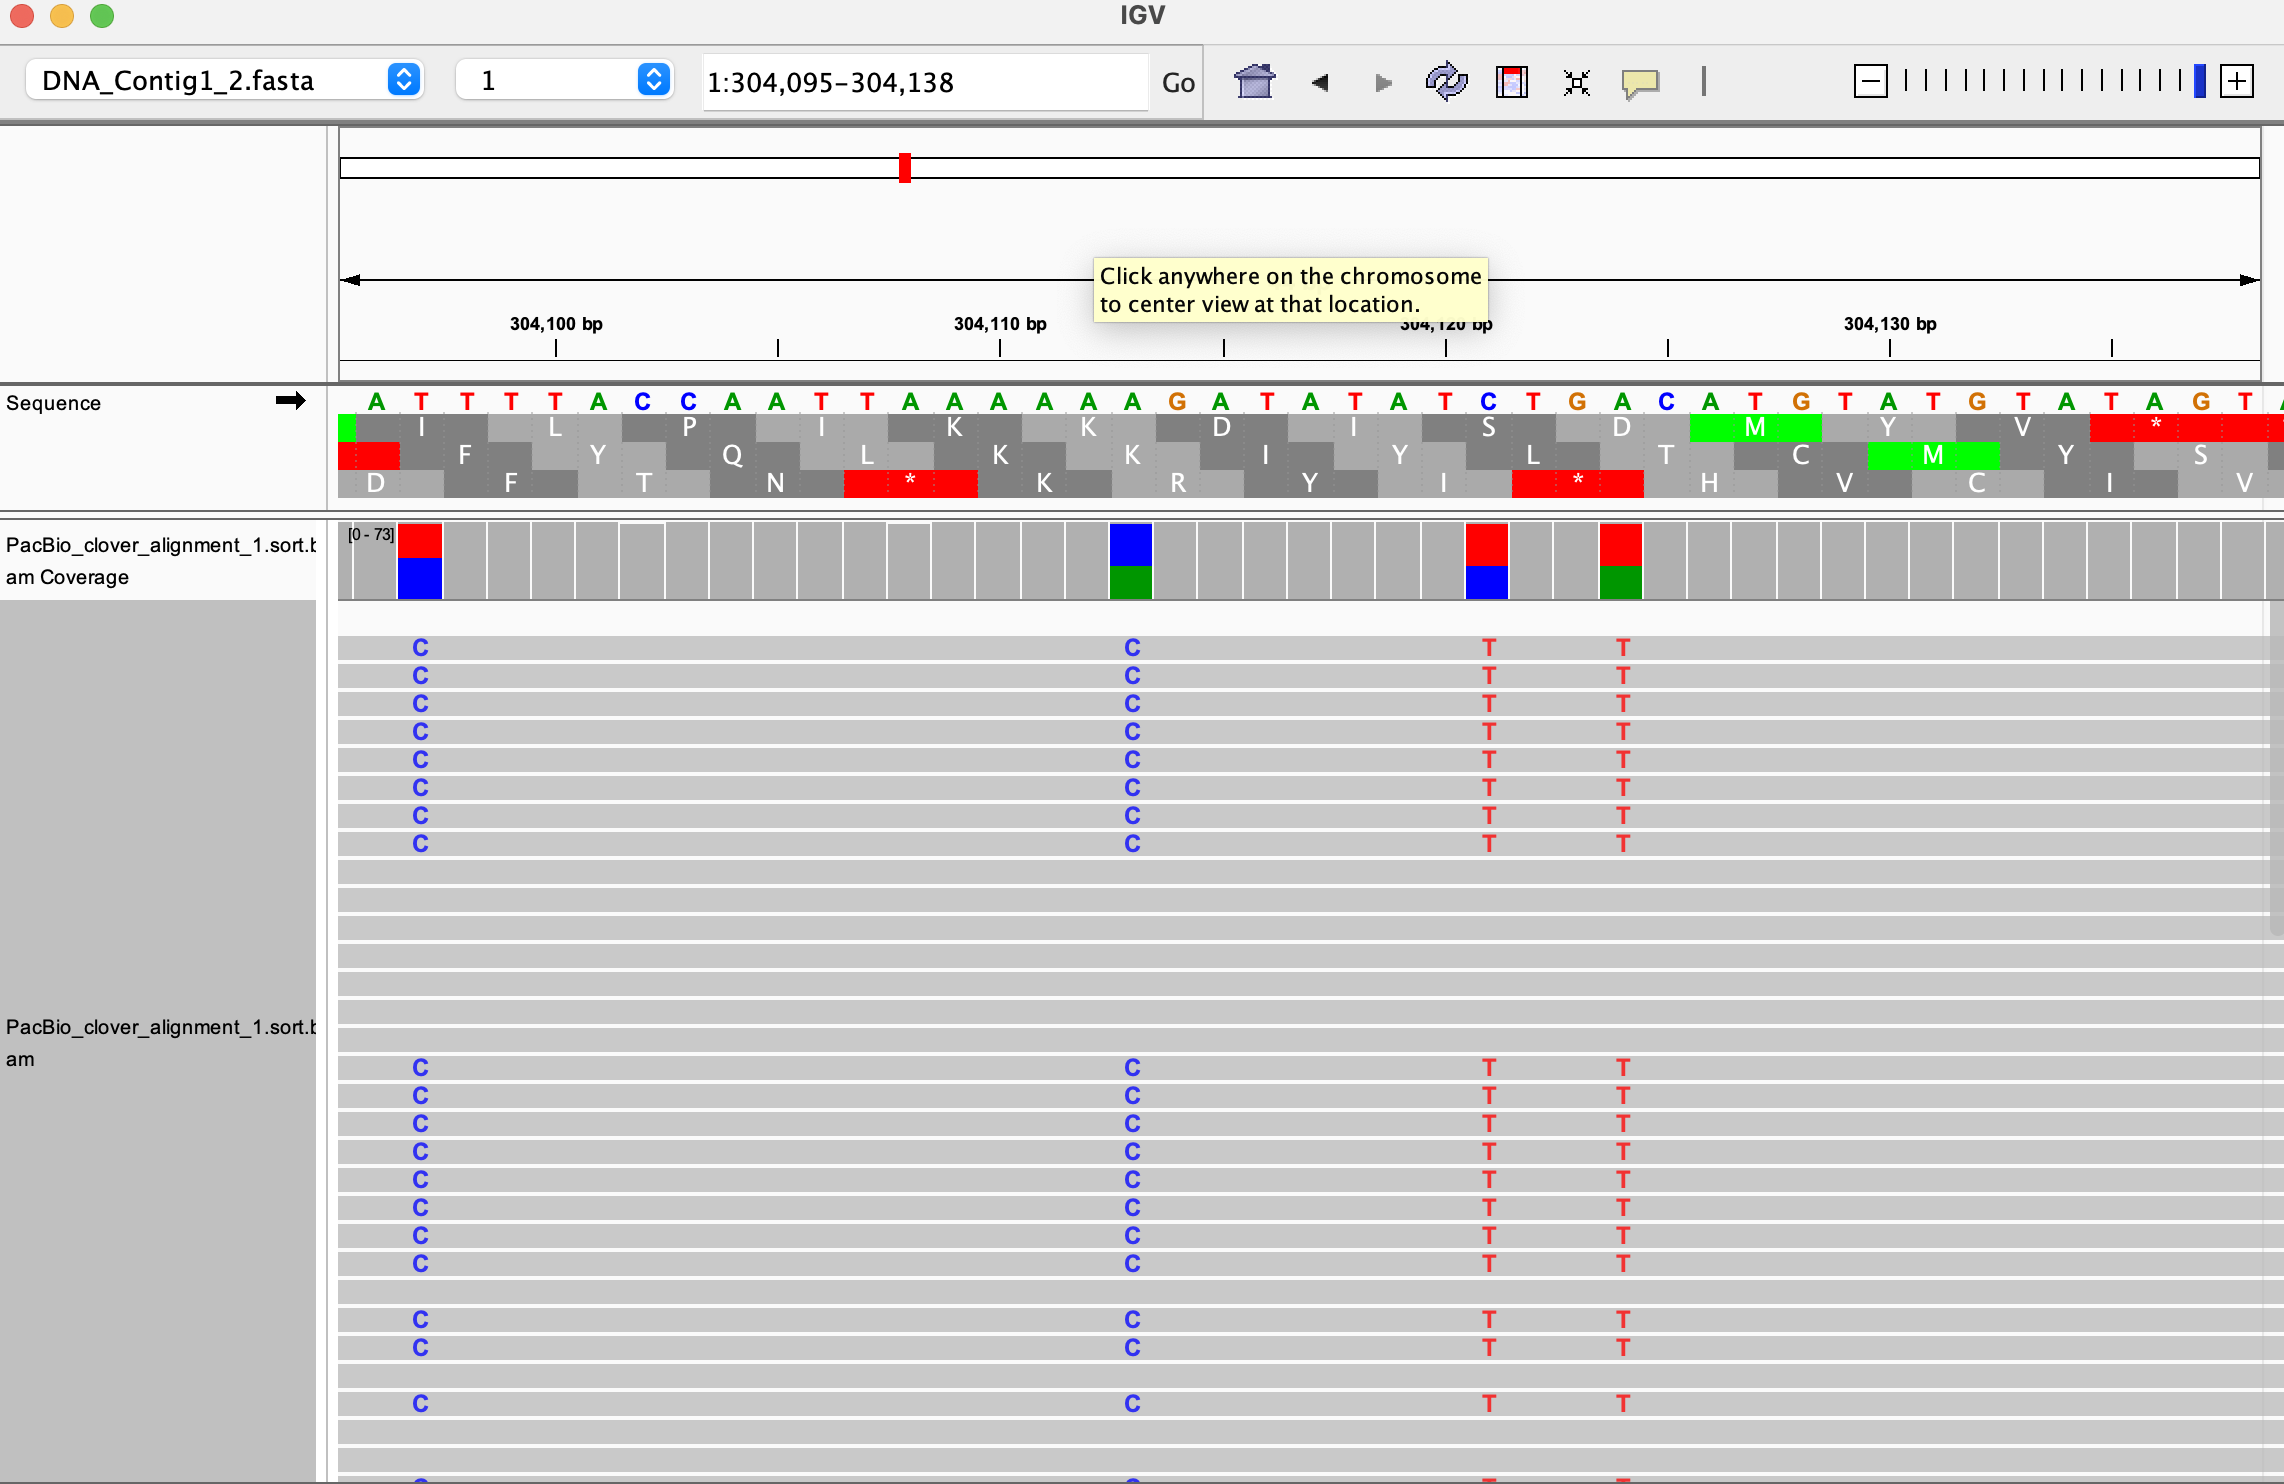

Now compare in IGV the two bam files
`PacBio_clover_alignment_1.sort.bam` and
`PacBio_clover_alignment_2.sort.bam`.

-   What do you observe when comparing the two BAM files?
-   Have a look at the polymorphic regions in IGV. Are they true
    polymorphisms?

Add to the visualization the third alignment
`PacBio_clover_alignment_1_2_mappb.sort.bam` in IGV.

-   Why do you see fluctuations in coverage and large regions without
    any apparent subgenome SNPs?
-   What are the major differences between the stats for the reads
    mapped to Contigs1&2 versus contig1 and contig2? What is your
    interpretation of the differences?

# RNA-seq mapping

In the `../Data` folder you will find 24 RNA-seq libraries, 12 `S10`
libraries and 12 `Tienshan` libraries. Each library is paired-end, which
is denoted by `R1` and `R2` at the end of two files having the same
name, such as `S10_1_1.R1.fastq` and `S10_1_1.R2.fastq`. We will align
each library separately and then merge the alignments to create two
final samples for `S10` and `Tienshan`.

First, we need to create a genome file for the reference fasta file of
contigs `1` and `2`. This is done with `STAR`, using the option
`--runMode genomeGenerate`. We also need to convert the gene annotation
from `gff` to `gtf` format with `gffread` to allow counting gene
transcripts. `STAR` is a very complex tool with many options, so it is
always useful to [have a reference
manual](https://physiology.med.cornell.edu/faculty/skrabanek/lab/angsd/lecture_notes/STARmanual.pdf).

In [ ]:
%%bash
gffread -T -o reference_data/white_clover_genes.gtf ../Data/Clover_Data/white_clover_genes.gff

In [ ]:
%%bash
STAR --runThreadN 8 \
--runMode genomeGenerate \
--genomeDir results/STAR_output/indexing_contigs_1_2 \
--genomeFastaFiles reference_data/DNA_Contig1_2.fasta \
--sjdbGTFfile reference_data/white_clover_genes.gtf 

We got a warning saying

    !!!!! WARNING: --genomeSAindexNbases 14 is too large for the genome size=2089554, which may cause seg-fault at the mapping step. Re-run genome generation with recommended --genomeSAindexNbases 9

meaning we need shorter strings of bases (9 bases instead of 14) to be
indexed, as our reference genome is very short, and too long strings
would cause many alignment errors. So we rerun the command with the
suggested option.

In [ ]:
%%bash
STAR --runThreadN 8 \
--runMode genomeGenerate \
--genomeDir results/STAR_output/indexing_contigs_1_2 \
--genomeFastaFiles reference_data/DNA_Contig1_2.fasta \
--sjdbGTFfile reference_data/white_clover_genes.gtf \
--genomeSAindexNbases 9

We use again `STAR` to align every single library for `S10`. We extract
the library name of each file and run STAR through each pair of files.
Note that plant introns are very rarely more than `5000 bp` and that you
are mapping to two homoeologous contigs that show high similarity,
especially in genic regions. We set the maximum size to 5000 using
`--alignIntronMax 5000`.

In [ ]:
%%bash
for i in `ls ../Data/Clover_Data/S10*.R1.fastq`
do

PREFIXNAME=`basename $i .R1.fastq`
echo "###############################################"
echo "##### ALIGNING PAIRED-END READS "$PREFIXNAME
echo "###############################################"
STAR --genomeDir results/STAR_output/indexing_contigs_1_2/ \
--runThreadN 8 \
--runMode alignReads \
--readFilesIn ../Data/Clover_Data/$PREFIXNAME.R1.fastq ../Data/Clover_Data/$PREFIXNAME.R2.fastq \
--outFileNamePrefix results/STAR_output/S10_align_contigs_1_2/$PREFIXNAME \
--outSAMtype BAM SortedByCoordinate \
--outSAMattributes Standard \
--quantMode GeneCounts \
--alignIntronMax 5000

done

Do the same alignment for `Tienshan` libraries

In [ ]:
%%bash
for i in `ls ../Data/Clover_Data/TI*.R1.fastq`
do

PREFIXNAME=`basename $i .R1.fastq`
echo "###############################################"
echo "##### ALIGNING PAIRED-END READS "$PREFIXNAME
echo "###############################################"
STAR --genomeDir results/STAR_output/indexing_contigs_1_2/ \
--runThreadN 8 \
--readFilesIn ../Data/Clover_Data/$PREFIXNAME.R1.fastq ../Data/Clover_Data/$PREFIXNAME.R2.fastq \
--outFileNamePrefix results/STAR_output/TI_align_contigs_1_2/$PREFIXNAME \
--outSAMtype BAM SortedByCoordinate \
--outSAMattributes Standard \
--quantMode GeneCounts \
--alignIntronMax 5000 

done

Run quality control on each aligned library with `MultiQC`. In this way
there will be a whole report to compare `S10` files and `Tienshan`
files.

In [ ]:
%%bash
multiqc --outdir results/multiqc_output/TI_STAR_align_1_2 \
            results/STAR_output/TI_align_contigs_1_2/

In [ ]:
%%bash
multiqc --outdir results/multiqc_output/S10_STAR_align_1_2 \
            results/STAR_output/S10_align_contigs_1_2/

We merge the outputs of each group of aligned libraries. Here is how the
files look like for the `Tienshan`.

In [ ]:
!ls -lh  results/STAR_output/TI_align_contigs_1_2/TI_*.sortedByCoord.out.bam 

Apply `samtools merge`

In [ ]:
%%bash
mkdir -p results/STAR_output/TI_align_contigs_1_2_merge/
samtools merge -f results/STAR_output/TI_align_contigs_1_2_merge/TI.sorted.bam results/STAR_output/TI_align_contigs_1_2/TI_*.sortedByCoord.out.bam 

In [ ]:
%%bash
mkdir -p results/STAR_output/S10_align_contigs_1_2_merge/
samtools merge -f results/STAR_output/S10_align_contigs_1_2_merge/S10.sorted.bam results/STAR_output/S10_align_contigs_1_2/S10_*.sortedByCoord.out.bam 

Index both merging outputs. A file in format `bam.bai` will appear in
their respective folders.

In [ ]:
%%bash
samtools index results/STAR_output/S10_align_contigs_1_2_merge/S10.sorted.bam

In [ ]:
%%bash
samtools index results/STAR_output/TI_align_contigs_1_2_merge/TI.sorted.bam

:::{.callout-note title="Wrapping up"}

In this exercise, you learnt to align various types of data after performing quality control for raw data. We looked at some of the options for the aligners and at how to use some of the basic samtools manipulation programs. The outputs from the RNA alignments will be used for the VCF file analysis in the next notebook, and the RNA alignments will be use for the bulk RNA data analysis.

:::